In [1]:
%matplotlib inline
import skmob
import pandas as pd
import skmob.measures.individual as ind_measure
import torch
import gpytorch
from gpytorch.kernels import RQKernel as RQ, RBFKernel as SE, \
PeriodicKernel as PER, ScaleKernel, LinearKernel as LIN, MaternKernel as MAT, \
SpectralMixtureKernel as SMK, PiecewisePolynomialKernel as PPK, CylindricalKernel as CYL
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from gpytorch.constraints import Interval
import time

# Import intra-package scripts
import utils.helper_func as helper_func
import utils.GP as GP
from utils.helper_func import dec_floor
import mobileDataToolkit.analysis as analysis
import mobileDataToolkit.preprocessing_v2 as preprocessing
import mobileDataToolkit.methods as methods
import mobileDataToolkit.metrics as metrics

import warnings
warnings.filterwarnings('ignore')

In [3]:
%pwd

'/Users/ekinokos2/Library/CloudStorage/OneDrive-UW/GPSImputeOct2023/tests'

In [5]:
file_path = "/Users/ekinokos2/Library/CloudStorage/OneDrive-UW/GPR/Data/seattle_2000_all_obs_sampled.csv"
df = pd.read_csv(file_path, header=0)

# Add month column
df['month'] = pd.DatetimeIndex(df['datetime']).month

# Group by user ID, find month with third most observations (average)
df_m = df.groupby('UID').apply(lambda x: x[x['month'] == x['month'].value_counts().index[2]])

# Keep only that month's data for each user
df_m = df_m.reset_index(drop=True)

df_m.UID.unique().shape # confirm that we have 50 users

(50,)

In [19]:
df_m['speed_limit_200'].describe()

count    260243.000000
mean        166.559688
std         142.869545
min           0.000000
25%          64.000000
50%         134.000000
75%         216.000000
max         552.000000
Name: speed_limit_200, dtype: float64

In [7]:
# Speed limits list, for filtering out unrealistic speeds
max_speed_list = [100, 200, 300]

# Quantify the number of observations that are above the speed limit
for speed_limit in max_speed_list:
    for uid in df_m.UID.unique():
        df_curr = df_m.loc[(df_m['UID'] == uid)]
        tdf = skmob.TrajDataFrame(df_curr, latitude='orig_lat', longitude='orig_long', datetime='datetime')
        f_tdf = skmob.preprocessing.filtering.filter(tdf, max_speed_kmh=speed_limit, include_loops=False)
        df_m.loc[(df_m['UID'] == uid), 'speed_limit_' + str(speed_limit)] = df_curr.shape[0] - f_tdf.shape[0]

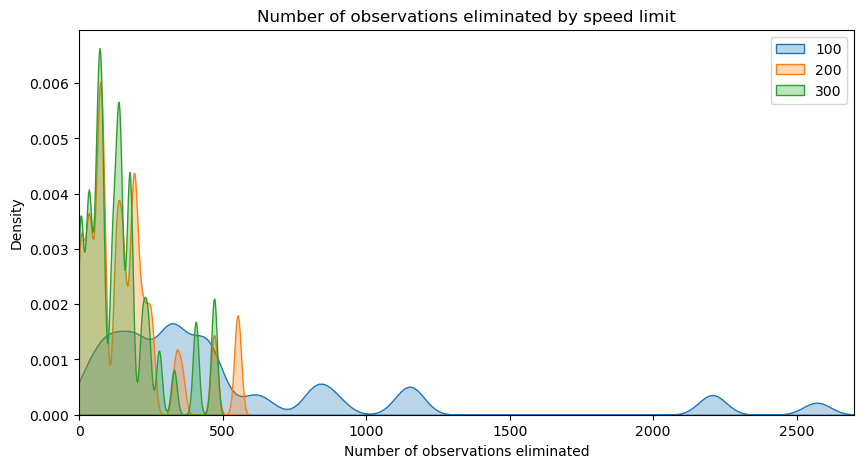

In [59]:
import seaborn as sns
# 200 seems to be the most reasonable speed limit
# Quantify the difference in the number of observations that we eliminate

# Plot the KDE of observations that are above the speed limit on the same histogram (color by speed limit)
fig, ax = plt.subplots(figsize=(10, 5))
for speed_limit in max_speed_list:
    sns.kdeplot(df_m['speed_limit_' + str(speed_limit)], ax=ax, label=str(speed_limit), fill=True, alpha=0.3)
    #sns.histplot(df_m['speed_limit_' + str(speed_limit)], ax=ax, label=str(speed_limit), kde=True, stat='density', binwidth=100, fill=True, alpha=0.3)
    #sns.displot(df_m['speed_limit_' + str(speed_limit)], ax=ax, label=str(speed_limit), kde=True, stat='density', binwidth=100, element='bars', fill=True, alpha=0.3)
ax.legend()
ax.set_xlim(0, 2700)
ax.set_xlabel('Number of observations eliminated')
ax.set_ylabel('Density')
ax.set_title('Number of observations eliminated by speed limit')
plt.show()